## Building Footprint Data
Loading bounding coordinates of buildings in the area.

Many studies suggest that the density of buildings in a
city influences ground temperatures and ultimately
contribute to the UHI issue. [Reference 3] This effect is
typically driven by buildings blocking the flow of air and
adding waste heat. For this challenge, we have
provided a building footprint dataset. Such information
could be used in your digital model as a feature that
drives local urban heating. 

In [7]:
import pandas as pd
import xml.etree.ElementTree as ET

def read_kml(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    
    ns = {'kml': 'http://www.opengis.net/kml/2.2'}
    
    data = []
    for placemark in root.findall('.//kml:Placemark', ns):
        building = {}
        
        # Get all SimpleData fields
        for simple_data in placemark.findall('.//kml:SimpleData', ns):
            name = simple_data.get('name')
            value = simple_data.text
            building[name] = value
            
        # Get coordinates
        coords_elem = placemark.find('.//kml:coordinates', ns)
        if coords_elem is not None:
            coords_text = coords_elem.text.strip()
            # Store raw coordinates string
            building['coordinates'] = coords_text
            
            # Calculate centroid (average of all coordinates)
            coords = []
            for coord in coords_text.split():
                lon, lat = map(float, coord.split(',')[:2])
                coords.append((lon, lat))
            
            # Add centroid as separate columns
            if coords:
                building['longitude'] = sum(c[0] for c in coords) / len(coords)
                building['latitude'] = sum(c[1] for c in coords) / len(coords)
        
        data.append(building)
    
    # Convert to DataFrame
    df = pd.DataFrame(data)
    
    # Convert numeric columns
    numeric_columns = ['fid', 'tessellate', 'extrude', 'visibility']
    for col in numeric_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='ignore')
            
    return df

# Example usage
kml_file = "../data/Building_Footprint.kml"  # Make sure this path is correct
buildings_df = read_kml(kml_file)

/var/folders/fg/gtyh9bm95ssfs2_k2xlfk2d80000gp/T/ipykernel_86670/409316873.py:47: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')


Location Identifiers:

* id: Unique identifier (e.g., "cugir009034.3") for each building footprint
* fid: A numeric ID (like 7624, 7625, etc.)
* layer: Always "clip_Bronx" in this dataset, indicating these are buildings in the Bronx area
* path: The original file path where this data was processed from


Geometric Properties:

* coordinates: Raw string of longitude/latitude pairs that define the building's polygon outline
* longitude: Calculated center point (centroid) longitude of the building
* latitude: Calculated center point (centroid) latitude of the building


Rendering Properties:

* tessellate (-1): Controls whether the geometry should follow the terrain
* extrude (0): Controls whether the geometry should be extended down to the ground
* visibility (-1): Controls whether the feature is initially visible

In [8]:
buildings_df = buildings_df.drop(columns=['tessellate', 'extrude', 'visibility', 'fid', 'layer', 'path'])

In [9]:
buildings_df.set_index('id', inplace=True)

In [10]:
display(buildings_df)

,coordinates,longitude,latitude
id,,,
cugir009034.3,"-73.919029,40.848199 -73.919329,40.847953 -73....",-73.919271,40.848072
cugir009034.4,"-73.921952,40.849629 -73.921911,40.849679 -73....",-73.921877,40.849621
cugir009034.5,"-73.920502,40.850113 -73.920453,40.850167 -73....",-73.920406,40.850095
cugir009034.6,"-73.92056,40.851403 -73.920531,40.851445 -73.9...",-73.920484,40.851394
cugir009034.142,"-73.912343,40.852184 -73.912472,40.852098 -73....",-73.912441,40.852190
...,...,...,...
cugir009062.5858,"-73.952668,40.779232 -73.95254,40.779428 -73.9...",-73.952174,40.779252
cugir009062.5859,"-73.949638,40.776133 -73.949312,40.776674 -73....",-73.948417,40.776069
cugir009062.5860,"-73.952102,40.768802 -73.951738,40.769309 -73....",-73.950884,40.768621


In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, Point, LineString
import matplotlib.pyplot as plt
from sklearn.neighbors import BallTree
import math
from scipy.spatial import Voronoi
from shapely.ops import unary_union, polygonize


def parse_coordinates(coord_str):
    """
    Convert the raw coordinates string to a list of (lon, lat) tuples
    Handles various formats including space-separated coordinate pairs
    """
    if not isinstance(coord_str, str):
        return []
        
    # Clean the string and handle various formats
    coord_str = coord_str.strip()
    
    # Try to detect the format based on the given example:
    # "-73.919029,40.848199 -73.919329,40.847953 -73...."
    if ' ' in coord_str and ',' in coord_str:
        # Format is likely "lon,lat lon,lat ..."
        pairs = coord_str.split()
        coordinates = []
        
        for pair in pairs:
            try:
                if ',' in pair:
                    lon, lat = pair.split(',', 1)
                    coordinates.append((float(lon), float(lat)))
            except (ValueError, IndexError):
                continue
                
        return coordinates
        
    # Fallback to the original method
    # Remove brackets and split by comma
    pairs = coord_str.replace('[', '').replace(']', '').split(',')
    
    # Group into lon/lat pairs
    coordinates = []
    for i in range(0, len(pairs), 2):
        if i+1 < len(pairs):  # Ensure we have both lon and lat
            try:
                lon = float(pairs[i])
                lat = float(pairs[i+1])
                coordinates.append((lon, lat))
            except ValueError:
                continue  # Skip invalid coordinates
    
    return coordinates

def calculate_building_features(df):
    """
    Calculate UHI-relevant features for each building and surrounding area
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing building footprint data with columns:
        id, coordinates, longitude, latitude
    
    Returns:
    --------
    gdf : GeoDataFrame
        GeoDataFrame with original data plus added UHI-relevant features
    """
    # Create a copy to avoid modifying the original
    df_copy = df.copy()
    
    # Parse coordinates and create geometry objects
    geometries = []
    areas = []
    perimeters = []
    
    for idx, row in df_copy.iterrows():
        try:
            coords = parse_coordinates(row['coordinates'])
            if len(coords) >= 3:  # Need at least 3 points for a polygon
                poly = Polygon(coords)
                geometries.append(poly)
                
                # Calculate area (m²)
                areas.append(poly.area * 111320**2)  # Rough conversion from degrees to meters
                
                # Calculate perimeter (m)
                perimeters.append(poly.length * 111320)  # Rough conversion from degrees to meters
            else:
                # Invalid polygon, use centroid as a Point instead
                geometries.append(Point(row['longitude'], row['latitude']))
                areas.append(0)
                perimeters.append(0)
        except (ValueError, TypeError):
            # Fallback to centroid if coordinates parsing fails
            geometries.append(Point(row['longitude'], row['latitude']))
            areas.append(0)
            perimeters.append(0)
    
    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(df_copy, geometry=geometries, crs="EPSG:4326")
    
    # Add building physical properties
    gdf['building_area_m2'] = areas
    gdf['building_perimeter_m'] = perimeters
    
    # Calculate building shape metrics (without height assumptions)
    # Compactness - ratio of area to perimeter (circular shapes have higher values)
    valid_perimeter = gdf['building_perimeter_m'] > 0
    gdf.loc[valid_perimeter, 'compactness'] = 4 * np.pi * gdf.loc[valid_perimeter, 'building_area_m2'] / (gdf.loc[valid_perimeter, 'building_perimeter_m']**2)
    gdf.loc[~valid_perimeter, 'compactness'] = np.nan
    
    # Calculate bounding box dimensions and aspect ratio
    def get_bbox_dimensions(geom):
        """Get width and length of the bounding box"""
        if hasattr(geom, 'bounds'):
            minx, miny, maxx, maxy = geom.bounds
            width = maxx - minx
            length = maxy - miny
            return width, length
        return np.nan, np.nan
        
    # Calculate for polygons only
    gdf['bbox_width'] = np.nan
    gdf['bbox_length'] = np.nan
    
    # Only process for Polygon geometries
    polygon_mask = gdf.geometry.geom_type == 'Polygon'
    
    # Apply dimension calculation only to polygons
    for idx, geom in zip(gdf[polygon_mask].index, gdf[polygon_mask].geometry):
        width, length = get_bbox_dimensions(geom)
        gdf.at[idx, 'bbox_width'] = width
        gdf.at[idx, 'bbox_length'] = length
    
    # Calculate aspect ratio (length/width)
    valid_dimensions = (gdf['bbox_width'] > 0) & (gdf['bbox_length'] > 0)
    gdf.loc[valid_dimensions, 'aspect_ratio'] = gdf.loc[valid_dimensions, 'bbox_length'] / gdf.loc[valid_dimensions, 'bbox_width']
    gdf.loc[~valid_dimensions, 'aspect_ratio'] = np.nan
    
    # Enhanced orientation calculation based on minimum bounding box
    gdf['orientation_degrees'] = np.nan
    
    # Calculate orientation for polygons with sufficient complexity
    orientation_mask = polygon_mask & (gdf['building_area_m2'] > 0)
    
    for idx, geom in zip(gdf[orientation_mask].index, gdf[orientation_mask].geometry):
        try:
            # Get the minimum rotated rectangle (envelope)
            rect = geom.minimum_rotated_rectangle
            
            if rect.geom_type == 'Polygon':
                # Extract the coordinates of the rectangle
                coords = list(rect.exterior.coords)
                
                # Calculate the angles of the rectangle sides
                angles = []
                for i in range(len(coords) - 1):
                    dx = coords[i+1][0] - coords[i][0]
                    dy = coords[i+1][1] - coords[i][1]
                    angle = math.degrees(math.atan2(dy, dx)) % 180
                    angles.append(angle)
                
                # The orientation is the angle that's closer to north (90 degrees)
                # or east (0 or 180 degrees)
                main_angle = min(angles, key=lambda x: min(abs(x-90), abs(x-0), abs(x-180)))
                gdf.at[idx, 'orientation_degrees'] = main_angle
        except:
            # Skip if there's an issue calculating orientation
            pass
    
    # Complexity - ratio of the actual perimeter to the perimeter of a circle with the same area
    # Only calculate for valid polygons with non-zero area and perimeter
    valid_area = gdf['building_area_m2'] > 0
    valid_mask = valid_area & valid_perimeter
    
    # Initialize complexity column with NaN
    gdf['complexity'] = np.nan
    
    # Calculate complexity only for valid geometries
    if valid_mask.any():
        # Calculate denominator first to avoid division issues
        denominator = 2 * np.sqrt(np.pi * gdf.loc[valid_mask, 'building_area_m2'])
        # Only calculate for rows with valid denominator
        valid_denom = denominator > 0
        if valid_denom.any():
            valid_indices = gdf.loc[valid_mask].index[valid_denom]
            gdf.loc[valid_indices, 'complexity'] = gdf.loc[valid_indices, 'building_perimeter_m'] / denominator[valid_denom]
    
    # NEW: Calculate sky view factor (SVF) approximation without height
    # SVF is the proportion of sky visible from a point on the ground
    # We can approximate potential SVF reduction using building density and arrangement
    gdf['svf_potential_reduction'] = np.nan
    
    # For polygons, calculate based on compactness and area
    # The idea: larger buildings with complex shapes tend to reduce SVF more
    gdf.loc[valid_mask, 'svf_potential_reduction'] = (
        (1 - gdf.loc[valid_mask, 'compactness']) * 
        np.log1p(gdf.loc[valid_mask, 'building_area_m2'] / 1000)  # log-transform to reduce impact of extreme values
    )
    
    # Normalize to 0-1 range for valid values
    svf_values = gdf['svf_potential_reduction'].dropna()
    if len(svf_values) > 0:
        min_svf = svf_values.min()
        max_svf = svf_values.max()
        if max_svf > min_svf:
            gdf.loc[valid_mask, 'svf_potential_reduction'] = (
                (gdf.loc[valid_mask, 'svf_potential_reduction'] - min_svf) / (max_svf - min_svf)
            )
    
    return gdf

def calculate_density_metrics(gdf, radius_m=100):
    """
    Calculate density-based metrics for UHI analysis within a specific radius
    
    Parameters:
    -----------
    gdf : GeoDataFrame
        GeoDataFrame with building footprints and properties
    radius_m : float
        Radius in meters to calculate density features
    
    Returns:
    --------
    gdf : GeoDataFrame
        Original GeoDataFrame with added density metrics
    """
    radius_suffix = f"{int(radius_m)}m"
    
    # Convert to projected CRS for accurate distance calculations (UTM zone depends on location)
    gdf_proj = gdf.to_crs(epsg=3857)  # Web Mercator projection
    
    # Create a BallTree for efficient nearest neighbor search
    coords = np.array([(geom.centroid.x, geom.centroid.y) for geom in gdf_proj.geometry])
    tree = BallTree(coords, metric='euclidean')
    
    # Find neighbors within radius
    indices = tree.query_radius(coords, r=radius_m)
    
    # Calculate density metrics
    building_count = []
    building_density = []
    floor_area_ratio = []
    built_up_ratio = []
    
    # NEW: Additional metrics
    building_spacing = []  # Average distance between buildings
    directional_exposure = []  # Exposure to wind in cardinal directions
    building_alignment = []  # Degree of alignment between buildings
    
    for i, idx_array in enumerate(indices):
        # Area of the circle
        circle_area = np.pi * radius_m**2
        
        # Count of buildings in radius (excluding self)
        count = len(idx_array) - 1
        building_count.append(count)
        
        # Building density (buildings per square km)
        density = count / (circle_area / 1000000)
        building_density.append(density)
        
        # Floor area ratio (total building area / land area)
        # Without height data, this is a 2D footprint coverage ratio
        total_building_area = gdf_proj.iloc[idx_array]['building_area_m2'].sum()
        far = total_building_area / circle_area
        floor_area_ratio.append(far)
        
        # Built-up ratio - different from FAR as it considers the actual geometric coverage
        # Use the sum of building areas as an approximation
        nearby_building_areas = gdf_proj.iloc[idx_array]['building_area_m2'].sum()
        built_up_ratio.append(nearby_building_areas / circle_area)
        
        # NEW: Calculate building spacing for buildings in the radius
        # First, get centroids of nearby buildings
        nearby_centroids = [gdf_proj.iloc[j].geometry.centroid for j in idx_array if j != i]
        
        # Calculate average nearest neighbor distance if there are nearby buildings
        if len(nearby_centroids) >= 2:  # Need at least 2 buildings
            # Current building centroid
            center = gdf_proj.iloc[i].geometry.centroid
            
            # Calculate distances to all other centroids
            distances = [center.distance(other) for other in nearby_centroids]
            
            # Average distance, excluding the furthest buildings to reduce radius edge effects
            if len(distances) >= 3:
                avg_distance = np.mean(sorted(distances)[:int(len(distances)*0.8)])
            else:
                avg_distance = np.mean(distances)
                
            building_spacing.append(avg_distance)
        else:
            # No nearby buildings or only one
            building_spacing.append(radius_m)  # Use radius as default spacing
        
        # NEW: Calculate directional exposure (wind flow potential)
        # Divide area into 4 quadrants (N, E, S, W) and calculate coverage in each
        center = gdf_proj.iloc[i].geometry.centroid
        
        # Count buildings in each quadrant
        quadrant_counts = [0, 0, 0, 0]  # N, E, S, W
        
        for j in idx_array:
            if j == i:
                continue
                
            other = gdf_proj.iloc[j].geometry.centroid
            dx = other.x - center.x
            dy = other.y - center.y
            
            # Determine quadrant (simplified cardinal directions)
            if abs(dx) > abs(dy):
                # Predominantly E-W direction
                if dx > 0:
                    # East
                    quadrant_counts[1] += 1
                else:
                    # West
                    quadrant_counts[3] += 1
            else:
                # Predominantly N-S direction
                if dy > 0:
                    # North
                    quadrant_counts[0] += 1
                else:
                    # South
                    quadrant_counts[2] += 1
        
        # Normalize by total count
        total_count = sum(quadrant_counts)
        if total_count > 0:
            quadrant_ratios = [count / total_count for count in quadrant_counts]
            
            # Calculate directional exposure as the standard deviation of quadrant ratios
            # Lower values indicate more uniform exposure, higher values indicate directional blockage
            directional_exposure.append(np.std(quadrant_ratios))
        else:
            directional_exposure.append(0)
        
        # NEW: Building alignment calculation
        # Calculate how aligned buildings are relative to each other
        # This affects street canyon effects and wind flow
        if len(nearby_centroids) >= 3:
            # Get orientation for buildings with valid orientation values
            orientations = [
                gdf.iloc[j]['orientation_degrees'] 
                for j in idx_array 
                if j != i and pd.notna(gdf.iloc[j]['orientation_degrees'])
            ]
            
            if len(orientations) >= 3:
                # Calculate circular statistics
                # Convert to radians
                rad_orientations = np.radians(orientations)
                
                # Calculate the mean resultant vector
                sin_sum = np.sum(np.sin(rad_orientations))
                cos_sum = np.sum(np.cos(rad_orientations))
                
                # Get the resultant vector length (0-1)
                # Values closer to 1 indicate stronger alignment
                R = np.sqrt(sin_sum**2 + cos_sum**2) / len(orientations)
                building_alignment.append(R)
            else:
                building_alignment.append(np.nan)
        else:
            building_alignment.append(np.nan)
    
    # Add metrics to the original GeoDataFrame with radius suffix
    gdf[f'nearby_building_count_{radius_suffix}'] = building_count
    gdf[f'building_density_per_km2_{radius_suffix}'] = building_density
    gdf[f'footprint_coverage_ratio_{radius_suffix}'] = floor_area_ratio
    gdf[f'built_up_ratio_{radius_suffix}'] = built_up_ratio
    
    # NEW: Add the new metrics
    gdf[f'avg_building_spacing_{radius_suffix}'] = building_spacing
    gdf[f'directional_exposure_{radius_suffix}'] = directional_exposure
    gdf[f'building_alignment_{radius_suffix}'] = building_alignment
    
    # NEW: Calculate street canyon potential
    # Combines building density, spacing, and alignment
    valid_alignment = ~pd.isna(gdf[f'building_alignment_{radius_suffix}'])
    gdf[f'street_canyon_potential_{radius_suffix}'] = np.nan
    
    gdf.loc[valid_alignment, f'street_canyon_potential_{radius_suffix}'] = (
        gdf.loc[valid_alignment, f'building_alignment_{radius_suffix}'] * 
        gdf.loc[valid_alignment, f'building_density_per_km2_{radius_suffix}'] / 
        np.maximum(gdf.loc[valid_alignment, f'avg_building_spacing_{radius_suffix}'], 1)
    ) / 1000  # Normalize to reasonable scale
    
    # NEW: Street network porosity approximation
    # This estimates how "porous" the street network might be based on building arrangement
    # Lower porosity = more UHI effect
    gdf[f'street_porosity_{radius_suffix}'] = 1 - (
        gdf[f'built_up_ratio_{radius_suffix}'] * 
        np.sqrt(gdf[f'building_density_per_km2_{radius_suffix}'] / 1000)
    )
    
    # Calculate impervious surface ratio (approximation without actual land cover data)
    # Improved coefficient model based on building density
    # In dense areas, expect more impervious surfaces between buildings
    impervious_base = 1.2  # Base coefficient
    density_factor = 0.4  # Additional factor based on building density
    
    # Calculate scaled coefficient (denser areas have higher coefficient)
    scaled_coefficient = impervious_base + (
        density_factor * gdf[f'building_density_per_km2_{radius_suffix}'] / 
        gdf[f'building_density_per_km2_{radius_suffix}'].quantile(0.9)
    )
    
    # Apply coefficient and cap at 1.0
    gdf[f'estimated_impervious_ratio_{radius_suffix}'] = np.minimum(
        gdf[f'built_up_ratio_{radius_suffix}'] * scaled_coefficient, 
        1.0  # Cap at 1.0 (100%)
    )
    
    # Calculate indicators of urban canyon formation (improved version)
    gdf[f'canyon_formation_potential_{radius_suffix}'] = (
        gdf[f'building_density_per_km2_{radius_suffix}'] / gdf[f'building_density_per_km2_{radius_suffix}'].max() * 
        gdf[f'built_up_ratio_{radius_suffix}'] * 
        (1 - gdf[f'street_porosity_{radius_suffix}'])
    )
    
    return gdf

def prepare_features_for_modeling(gdf):
    """
    Prepare standardized features from building footprint data for UHI modeling
    without introducing biased pre-calculated indices
    
    Parameters:
    -----------
    gdf : GeoDataFrame
        GeoDataFrame with building footprint data and calculated metrics
    
    Returns:
    --------
    gdf : GeoDataFrame
        Original GeoDataFrame with standardized features suitable for modeling
    """
    # Find radius suffixes in column names
    radius_suffixes = []
    for col in gdf.columns:
        if 'built_up_ratio_' in col:
            suffix = col.split('built_up_ratio_')[1]
            radius_suffixes.append(suffix)
    
    # If no density calculations were done, return the dataframe as is
    if not radius_suffixes:
        return gdf
    
    # Standardize relevant numeric features
    # This is different from normalization - it centers data around mean with unit variance
    # This approach is more suitable for modeling than the previous 0-1 normalization
    numeric_features = [
        # Building physical properties
        'building_area_m2',
        'building_perimeter_m',
        'compactness',
        'aspect_ratio',
        'complexity',
        'svf_potential_reduction',
        
        # Ventilation metrics
        'ventilation_corridor_width',
        'ventilation_potential',
        'wind_exposure',
        
        # Morphological metrics
        'rugosity_300m',
        'heat_sink_potential'
    ]
    
    # Add radius-specific features
    for suffix in radius_suffixes:
        radius_features = [
            f'nearby_building_count_{suffix}',
            f'building_density_per_km2_{suffix}',
            f'footprint_coverage_ratio_{suffix}',
            f'built_up_ratio_{suffix}',
            f'estimated_impervious_ratio_{suffix}',
            f'canyon_formation_potential_{suffix}',
            f'avg_building_spacing_{suffix}',
            f'directional_exposure_{suffix}',
            f'building_alignment_{suffix}',
            f'street_canyon_potential_{suffix}',
            f'street_porosity_{suffix}'
        ]
        numeric_features.extend(radius_features)
    
    # Standardize each numeric feature individually
    # (value - mean) / std to get z-scores
    # This creates features with mean=0 and std=1, suitable for most ML models
    for feature in numeric_features:
        if feature in gdf.columns:
            # Skip features with all zeros or NaN
            if gdf[feature].isna().all() or (gdf[feature] == 0).all():
                continue
                
            # Get non-NaN values
            valid_values = gdf[feature].dropna()
            if len(valid_values) == 0:
                continue
                
            # Calculate mean and std from valid values
            feature_mean = valid_values.mean()
            feature_std = valid_values.std()
            
            # Skip if std is zero (constant feature)
            if feature_std == 0:
                continue
                
            # Create standardized feature
            std_feature_name = f'{feature}_std'
            gdf[std_feature_name] = (gdf[feature] - feature_mean) / feature_std
    
    # NEW: Create combined UHI vulnerability indices
    # These indices combine multiple factors known to influence UHI
    
    # Ventilation Restriction Index
    # High values = poor ventilation = more UHI
    vent_features = ['ventilation_potential_norm', 'wind_exposure', 'street_porosity_100m']
    valid_features = [f for f in vent_features if f in gdf.columns and not gdf[f].isna().all()]
    
    if len(valid_features) >= 2:
        # Invert features where higher values mean better ventilation
        for f in valid_features:
            if 'ventilation' in f or 'wind' in f or 'porosity' in f:
                gdf[f'{f}_inv'] = 1 - gdf[f]
        
        # Create index using inverted features
        inv_features = [f'{f}_inv' for f in valid_features]
        gdf['ventilation_restriction_index'] = gdf[inv_features].mean(axis=1)
    
    # Building Morphology Index
    # High values = morphology that traps heat = more UHI
    morph_features = ['svf_potential_reduction', 'complexity', 'heat_sink_potential', 
                      'canyon_formation_potential_100m']
    valid_features = [f for f in morph_features if f in gdf.columns and not gdf[f].isna().all()]
    
    if len(valid_features) >= 2:
        gdf['building_morphology_index'] = gdf[valid_features].mean(axis=1)
    
    # Urban Density Index
    # High values = higher density = more UHI
    dens_features = ['building_density_per_km2_500m', 'built_up_ratio_500m', 
                    'estimated_impervious_ratio_500m']
    valid_features = [f for f in dens_features if f in gdf.columns and not gdf[f].isna().all()]
    
    if len(valid_features) >= 2:
        # Normalize each feature to 0-1 scale
        for f in valid_features:
            valid_vals = gdf[f].dropna()
            if len(valid_vals) > 0:
                min_val = valid_vals.min()
                max_val = valid_vals.max()
                if max_val > min_val:
                    gdf[f'{f}_norm'] = (gdf[f] - min_val) / (max_val - min_val)
        
        # Create index using normalized features
        norm_features = [f'{f}_norm' for f in valid_features]
        valid_norm = [f for f in norm_features if f in gdf.columns]
        if valid_norm:
            gdf['urban_density_index'] = gdf[valid_norm].mean(axis=1)
    
    # Combined UHI Vulnerability Index
    # Combines all three sub-indices
    indices = ['ventilation_restriction_index', 'building_morphology_index', 'urban_density_index']
    valid_indices = [idx for idx in indices if idx in gdf.columns and not gdf[idx].isna().all()]
    
    if len(valid_indices) >= 2:
        gdf['uhi_vulnerability_index'] = gdf[valid_indices].mean(axis=1)
        
        # Normalize to 0-1 scale
        valid_vals = gdf['uhi_vulnerability_index'].dropna()
        if len(valid_vals) > 0:
            min_val = valid_vals.min()
            max_val = valid_vals.max()
            if max_val > min_val:
                gdf['uhi_vulnerability_normalized'] = (
                    (gdf['uhi_vulnerability_index'] - min_val) / (max_val - min_val)
                )
    
    return gdf

def calculate_morphological_metrics(gdf):
    """
    Calculate morphological metrics related to UHI
    
    Parameters:
    -----------
    gdf : GeoDataFrame
        GeoDataFrame with building footprints and properties
    
    Returns:
    --------
    gdf : GeoDataFrame
        Original GeoDataFrame with added morphological metrics
    """
    # Convert to projected CRS for accurate calculations
    gdf_proj = gdf.to_crs(epsg=3857)
    
    # Function to calculate rugosity (surface roughness) for each neighborhood
    def calculate_rugosity(geom, nearby_geometries):
        """Calculate rugosity based on height variation of buildings"""
        # Without actual height, use building area as a proxy for height
        # This assumes larger buildings tend to be taller (not always true but a reasonable proxy)
        if len(nearby_geometries) < 3:
            return 0
            
        # Get areas of nearby buildings
        areas = [g.area for g in nearby_geometries]
        
        # Calculate coefficient of variation (normalized measure of dispersion)
        cv = np.std(areas) / np.mean(areas) if np.mean(areas) > 0 else 0
        
        # Scale to reasonable range (0-1)
        rugosity = min(cv, 1.0)
        
        return rugosity
    
    # Create a BallTree for efficient nearest neighbor search
    coords = np.array([(geom.centroid.x, geom.centroid.y) for geom in gdf_proj.geometry])
    tree = BallTree(coords, metric='euclidean')
    
    # Use a different radius for morphological analysis
    radius_m = 300
    indices = tree.query_radius(coords, r=radius_m)
    
    # Calculate rugosity for each building
    rugosity_values = []
    
    for i, idx_array in enumerate(indices):
        nearby_geoms = [gdf_proj.iloc[j].geometry for j in idx_array if gdf_proj.iloc[j].geometry.geom_type == 'Polygon']
        rugosity = calculate_rugosity(gdf_proj.iloc[i].geometry, nearby_geoms)
        rugosity_values.append(rugosity)
    
    gdf['rugosity_300m'] = rugosity_values
    
    # NEW: Attempt to identify potential "heat sinks" (areas that might accumulate heat)
    # Based on building arrangement and spacing
    gdf['heat_sink_potential'] = np.nan
    
    # Calculate for each building with sufficient neighbors
    for i, idx_array in enumerate(indices):
        if len(idx_array) < 5:  # Skip if too few neighbors
            continue
            
        # Get current building and neighbors
        current_geom = gdf_proj.iloc[i].geometry
        nearby_geoms = [gdf_proj.iloc[j].geometry for j in idx_array if j != i]
        
        # Skip non-polygon geometries
        if current_geom.geom_type != 'Polygon' or not all(g.geom_type == 'Polygon' for g in nearby_geoms):
            continue
            
        # Current building area
        current_area = current_geom.area
        
        # Calculate total area of surrounding buildings
        surrounding_area = sum(g.area for g in nearby_geoms)
        
        # Calculate average distance to nearest buildings
        distances = [current_geom.distance(g) for g in nearby_geoms]
        distances = sorted(distances)[:min(5, len(distances))]  # Consider 5 closest
        avg_distance = np.mean(distances) if distances else np.nan
        
        if pd.notna(avg_distance) and avg_distance > 0:
            # Heat sink potential is high when:
            # - Building is relatively small compared to surroundings (trapped)
            # - Nearby buildings are close (limited air flow)
            # - Surrounding buildings are large (more heat generation/reflection)
            
            size_ratio = min(surrounding_area / max(current_area, 1), 10)  # Cap at 10
            proximity_factor = 100 / max(avg_distance, 1)  # Higher for closer buildings
            
            gdf.at[gdf.index[i], 'heat_sink_potential'] = (
                size_ratio * proximity_factor / 100  # Scale to reasonable range
            )
    
    # NEW: Urban fabric pattern analysis
    # This detects patterns in building arrangements that affect UHI
    
    # Convert certain features to relative percentile ranks
    # This helps normalize the features for pattern detection
    for col in ['building_area_m2', 'complexity', 'rugosity_300m']:
        if col in gdf.columns:
            # Calculate percentile ranks for non-NaN values
            valid_mask = ~pd.isna(gdf[col])
            if valid_mask.any() and gdf.loc[valid_mask, col].nunique() > 1:
                gdf.loc[valid_mask, f'{col}_rank'] = (
                    gdf.loc[valid_mask, col].rank(pct=True)
                )
    
    # Identify urban patterns based on the percentile ranks
    # These patterns affect UHI differently
    pattern_conditions = {
        'compact_block': (
            (gdf['building_area_m2_rank'] > 0.7) & 
            (gdf['complexity_rank'] < 0.3)
        ),
        'dispersed_suburban': (
            (gdf['building_area_m2_rank'] < 0.4) & 
            (gdf['rugosity_300m_rank'] < 0.3)
        ),
        'organic_cluster': (
            (gdf['complexity_rank'] > 0.7) & 
            (gdf['rugosity_300m_rank'] > 0.6)
        ),
        'linear_corridor': (
            (gdf['complexity_rank'] > 0.5) & 
            (gdf['rugosity_300m_rank'] < 0.5) &
            (gdf['aspect_ratio'] > 2)
        )
    }
    
    # Create columns for each pattern
    for pattern, condition in pattern_conditions.items():
        # Fill NaN values with False
        filled_condition = condition.fillna(False)
        gdf[f'pattern_{pattern}'] = filled_condition
    
    return gdf

def calculate_ventilation_potential(gdf):
    """
    Calculate ventilation potential metrics for UHI analysis
    
    Parameters:
    -----------
    gdf : GeoDataFrame
        GeoDataFrame with building footprints and properties
    
    Returns:
    --------
    gdf : GeoDataFrame
        Original GeoDataFrame with added ventilation metrics
    """
    # Only proceed if we have enough buildings
    if len(gdf) < 10:
        return gdf
    
    # Convert to projected CRS for accurate calculations
    gdf_proj = gdf.to_crs(epsg=3857)
    
    # Create a BallTree for efficient nearest neighbor search
    coords = np.array([(geom.centroid.x, geom.centroid.y) for geom in gdf_proj.geometry])
    tree = BallTree(coords, metric='euclidean')
    
    # Use 300m radius for ventilation analysis
    radius_m = 300
    indices = tree.query_radius(coords, r=radius_m)
    
    # NEW: Calculate ventilation corridors and potential air flow channels
    # This helps assess natural cooling potential
    
    ventilation_potential = []
    wind_exposure = []
    corridor_width = []
    
    for i, idx_array in enumerate(indices):
        if len(idx_array) < 5:  # Skip if too few neighbors
            ventilation_potential.append(np.nan)
            wind_exposure.append(np.nan)
            corridor_width.append(np.nan)
            continue
        
        # Get current building and neighbors
        current_point = gdf_proj.iloc[i].geometry.centroid
        nearby_geoms = [gdf_proj.iloc[j].geometry for j in idx_array if j != i]
        
        try:
            # Create a Voronoi diagram of the area to identify potential corridors
            # Extract centroids of all geometries
            nearby_points = [g.centroid for g in nearby_geoms]
            all_points = [current_point] + nearby_points
            
            # Convert to array of coordinates for Voronoi diagram
            point_coords = np.array([[p.x, p.y] for p in all_points])
            
            # Calculate Voronoi diagram (will have issues at boundaries, but useful for interior cells)
            vor = Voronoi(point_coords)
            
            # Get the ridge lines from the Voronoi diagram
            # These represent edges between adjacent cells (potential corridors)
            ridge_lines = []
            for ridge in vor.ridge_vertices:
                if -1 not in ridge:  # Skip ridges that extend to infinity
                    # Get the coordinates of the ridge vertices
                    ridge_line = LineString([vor.vertices[i] for i in ridge])
                    ridge_lines.append(ridge_line)
            
            if ridge_lines:
                # Calculate average corridor width (distance between buildings)
                # Use the length of Voronoi ridges as proxy for corridor width
                avg_width = np.mean([line.length for line in ridge_lines])
                corridor_width.append(avg_width)
                
                # Calculate ventilation potential based on:
                # - Corridor width (wider = better ventilation)
                # - Building density (lower = better ventilation)
                # - Building alignment (higher alignment can create wind tunnels)
                
                # Extract density and alignment metrics
                density = gdf.iloc[i].get('building_density_per_km2_300m', np.nan)
                alignment = gdf.iloc[i].get('building_alignment_300m', np.nan)
                
                if pd.notna(density) and pd.notna(alignment):
                    # Ventilation potential formula:
                    # Higher values = better ventilation = reduced UHI
                    ventilation_pot = (avg_width * alignment) / max(np.sqrt(density), 1)
                    ventilation_potential.append(ventilation_pot)
                else:
                    ventilation_potential.append(np.nan)
                
                # Calculate wind exposure (how exposed a building is to wind from any direction)
                # Based on the longest unobstructed distance in any direction
                exposure_distances = []
                
                for angle in range(0, 360, 20):  # Check every 20 degrees
                    # Convert angle to radians
                    rad_angle = math.radians(angle)
                    
                    # Calculate a point 500m away in this direction
                    end_x = current_point.x + 500 * math.cos(rad_angle)
                    end_y = current_point.y + 500 * math.sin(rad_angle)
                    test_line = LineString([(current_point.x, current_point.y), (end_x, end_y)])
                    
                    # Check if this line intersects any nearby buildings
                    intersections = [test_line.intersects(g) for g in nearby_geoms]
                    
                    # If no intersections, use full distance (500m)
                    if not any(intersections):
                        exposure_distances.append(500)
                    else:
                        # Calculate distance to nearest intersection
                        intersection_distances = []
                        for j, intersects in enumerate(intersections):
                            if intersects:
                                intersection_dist = current_point.distance(nearby_geoms[j])
                                intersection_distances.append(intersection_dist)
                        
                        # Use the nearest intersection distance
                        if intersection_distances:
                            exposure_distances.append(min(intersection_distances))
                        else:
                            exposure_distances.append(500)
                
                # Use the average of exposure distances as wind exposure metric
                wind_exposure.append(np.mean(exposure_distances))
            else:
                corridor_width.append(np.nan)
                ventilation_potential.append(np.nan)
                wind_exposure.append(np.nan)
        except:
            # Skip if there's an error in Voronoi calculation
            corridor_width.append(np.nan)
            ventilation_potential.append(np.nan)
            wind_exposure.append(np.nan)
    
    # Add metrics to the GeoDataFrame
    gdf['ventilation_corridor_width'] = corridor_width
    gdf['ventilation_potential'] = ventilation_potential
    gdf['wind_exposure'] = wind_exposure
    
    # NEW: Normalize ventilation potential to 0-1 scale for easier interpretation
    valid_vent = gdf['ventilation_potential'].dropna()
    if len(valid_vent) > 0:
        min_vent = valid_vent.min()
        max_vent = valid_vent.max()
        if max_vent > min_vent:
            gdf['ventilation_potential_norm'] = np.nan
            gdf.loc[~pd.isna(gdf['ventilation_potential']), 'ventilation_potential_norm'] = (
                (gdf.loc[~pd.isna(gdf['ventilation_potential']), 'ventilation_potential'] - min_vent) / 
                (max_vent - min_vent)
            )
    
    return gdf

/var/folders/fg/gtyh9bm95ssfs2_k2xlfk2d80000gp/T/ipykernel_86670/2151909115.py:640: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  nearby_geoms = [gdf_proj.iloc[j].geometry for j in idx_array if gdf_proj.iloc[j].geometry.type == 'Polygon']
/var/folders/fg/gtyh9bm95ssfs2_k2xlfk2d80000gp/T/ipykernel_86670/2151909115.py:660: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if current_geom.type != 'Polygon' or not all(g.type == 'Polygon' for g in nearby_geoms):
/Users/georgeimperial/Documents/GitHub/urban-heat-mitigation/.venv/lib/python3.12/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/georgeimperial/Documents/GitHub/urban-heat-mitigation/.venv/lib/python3.12/site-packages/shapely/measurement.py:72: Ru

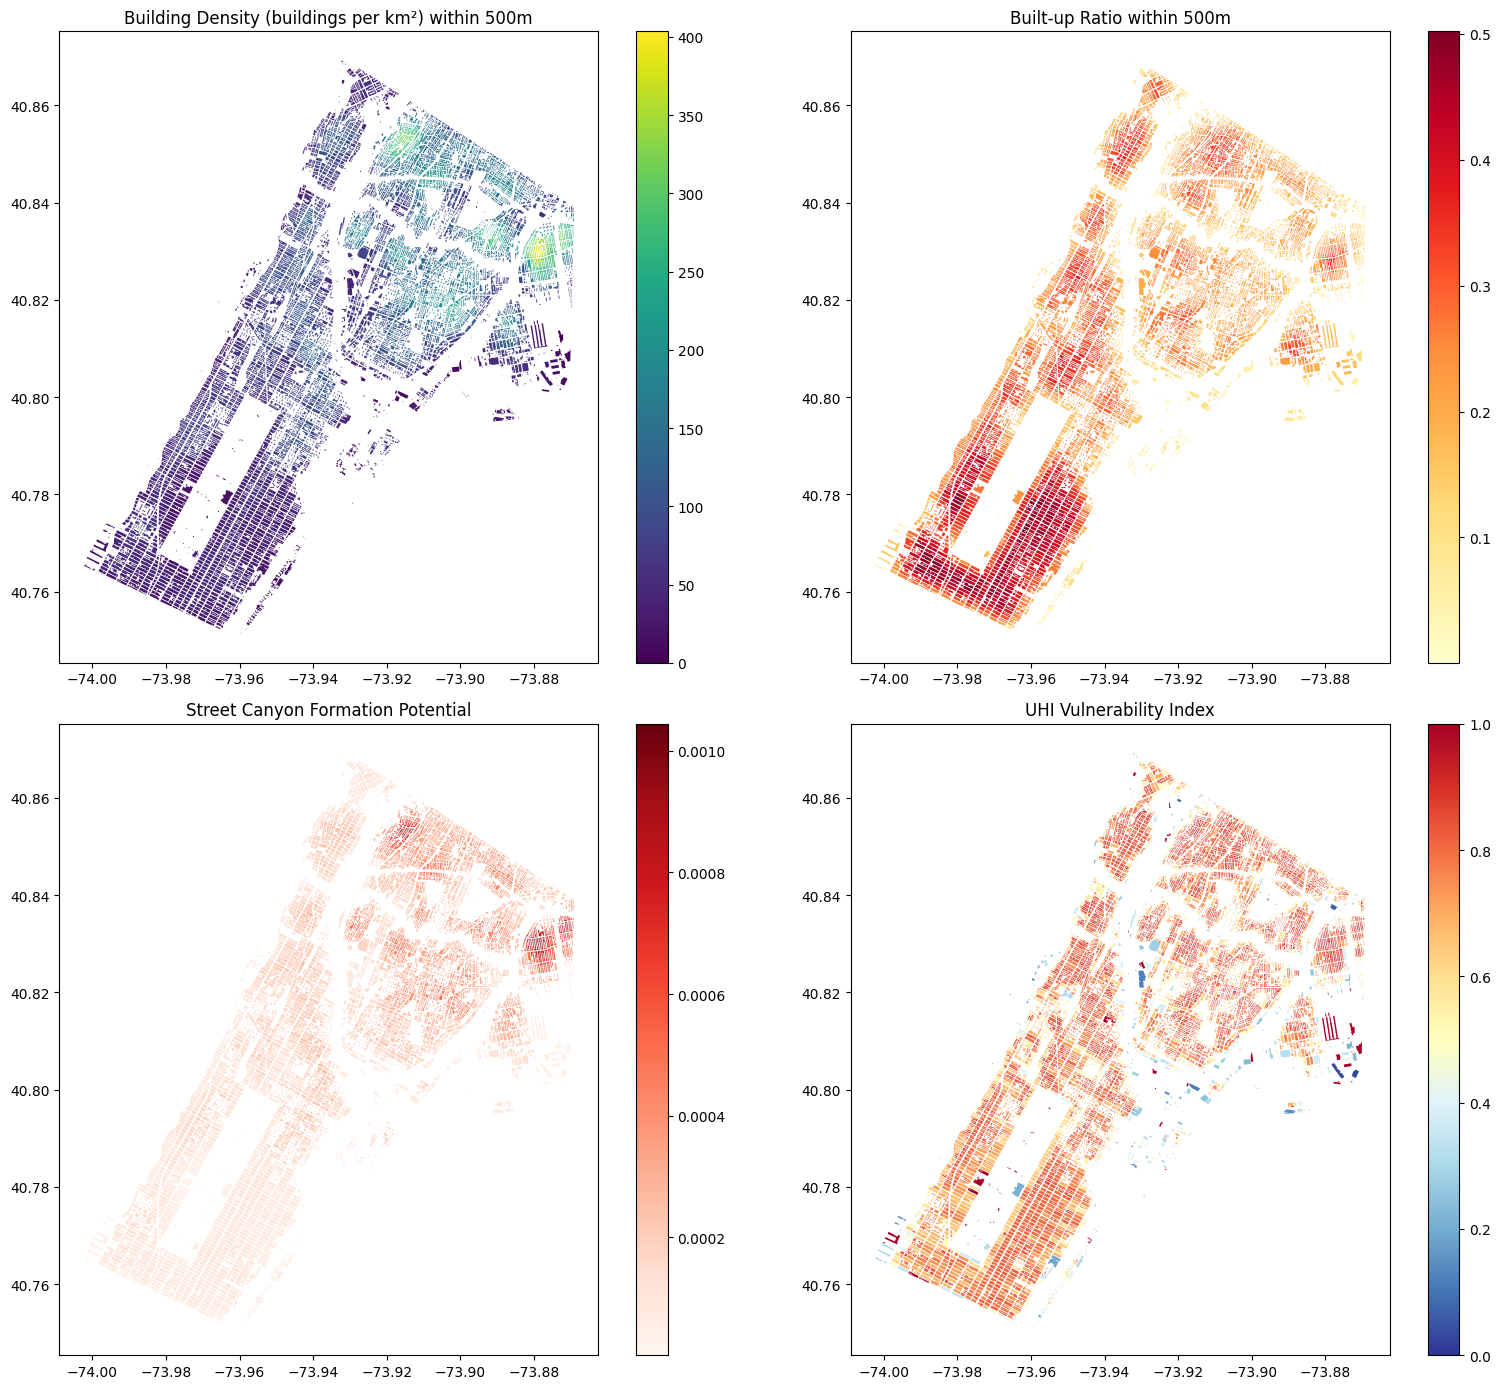

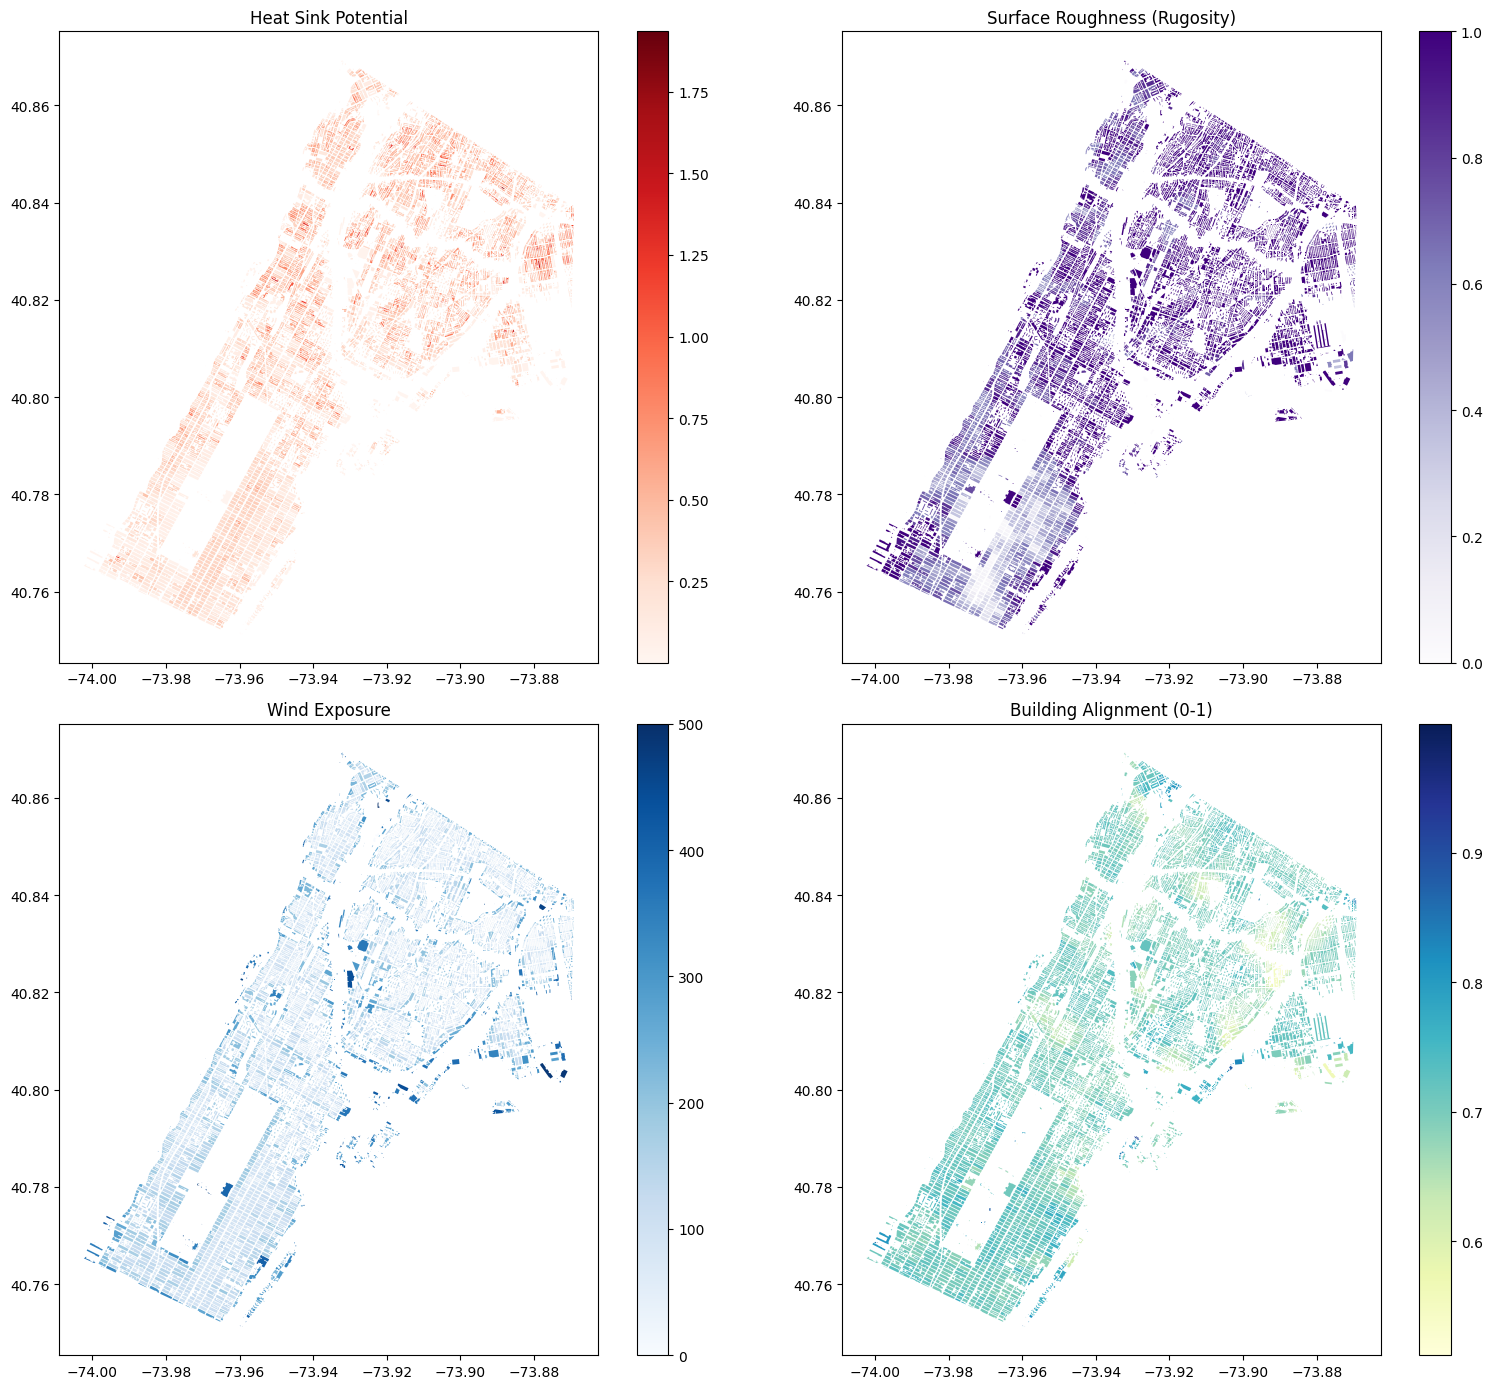

Identified 944 potential UHI hotspots out of 9436 buildings

UHI Mitigation Recommendations:
        urban_pattern  building_count  \
0       compact_block             250   
1  dispersed_suburban             522   
2     organic_cluster            1551   
3     linear_corridor              25   

                                 mitigation_strategy  \
0  Green roofs, vertical gardens, high-albedo mat...   
1  Tree canopy increase, permeable surfaces for d...   
2  Enhanced ventilation corridors, small pocket p...   
3     Street trees, cool pavements, shade structures   

                                           reasoning  
0  Compact blocks limit natural ventilation and c...  
1  Dispersed suburban areas have potential for in...  
2  Organic clusters often lack organized ventilat...  
3  Linear corridors can be improved with shading ...  


In [13]:
def analyze_building_footprints_for_uhi(df, output_file=None, plot=False, calculate_advanced_metrics=True):
    """
    Main function to extract UHI-relevant features from building footprints
    with enhanced metrics for improved UHI modeling
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing building footprint data with columns:
        id, coordinates, longitude, latitude
    output_file : str, optional
        Path to save the output GeoDataFrame as a GeoJSON file
    plot : bool, default=False
        Whether to generate and show plots of the results
    calculate_advanced_metrics : bool, default=True
        Whether to calculate advanced morphological and ventilation metrics
        
    Returns:
    --------
    gdf : GeoDataFrame
        GeoDataFrame with all calculated UHI-relevant features
    """
    # Calculate basic building features
    gdf = calculate_building_features(df)
    
    # Calculate density-based metrics (100m and 500m radii)
    gdf = calculate_density_metrics(gdf, radius_m=100)
    gdf = calculate_density_metrics(gdf, radius_m=500)
    
    # Calculate advanced metrics if requested
    if calculate_advanced_metrics:
        # Add morphological analysis
        gdf = calculate_morphological_metrics(gdf)
        
        # Add ventilation potential analysis
        gdf = calculate_ventilation_potential(gdf)
    
    # Prepare features for modeling (standardize and create indices)
    gdf = prepare_features_for_modeling(gdf)
    
    # Save to file if specified
    if output_file:
        gdf.to_file(output_file, driver='GeoJSON')
    
    # Generate plots if requested
    if plot:
        # Create a multi-subplot figure for better comparison
        fig, axes = plt.subplots(2, 2, figsize=(16, 14))
        
        # Plot building density
        gdf.plot(column='building_density_per_km2_500m', cmap='viridis', 
                 linewidth=0.1, ax=axes[0, 0], legend=True)
        axes[0, 0].set_title('Building Density (buildings per km²) within 500m')
        
        # Plot ventilation potential if available
        if 'ventilation_potential_norm' in gdf.columns:
            gdf.plot(column='ventilation_potential_norm', cmap='coolwarm',
                    linewidth=0.1, ax=axes[0, 1], legend=True)
            axes[0, 1].set_title('Ventilation Potential (higher = better cooling)')
        else:
            # Fallback to built-up ratio
            gdf.plot(column='built_up_ratio_500m', cmap='YlOrRd',
                    linewidth=0.1, ax=axes[0, 1], legend=True)
            axes[0, 1].set_title('Built-up Ratio within 500m')
        
        # Plot street canyon potential if available
        if 'street_canyon_potential_500m' in gdf.columns:
            gdf.plot(column='street_canyon_potential_500m', cmap='Reds',
                    linewidth=0.1, ax=axes[1, 0], legend=True)
            axes[1, 0].set_title('Street Canyon Formation Potential')
        else:
            # Fallback to complexity
            gdf.plot(column='complexity', cmap='Purples',
                    linewidth=0.1, ax=axes[1, 0], legend=True)
            axes[1, 0].set_title('Building Complexity')
        
        # Plot UHI vulnerability index if available
        if 'uhi_vulnerability_normalized' in gdf.columns:
            gdf.plot(column='uhi_vulnerability_normalized', cmap='RdYlBu_r',
                    linewidth=0.1, ax=axes[1, 1], legend=True)
            axes[1, 1].set_title('UHI Vulnerability Index')
        else:
            # Fallback to impervious ratio
            gdf.plot(column='estimated_impervious_ratio_500m', cmap='YlOrBr',
                    linewidth=0.1, ax=axes[1, 1], legend=True)
            axes[1, 1].set_title('Estimated Impervious Surface Ratio')
        
        plt.tight_layout()
        plt.savefig('./results/building_footprint/uhi_analysis_plots.png', dpi=300)
        plt.show()
        
        # Optional: Additional plots for advanced metrics
        if calculate_advanced_metrics and 'heat_sink_potential' in gdf.columns:
            fig, axes = plt.subplots(2, 2, figsize=(16, 14))
            
            # Plot heat sink potential
            valid_heat_sink = ~pd.isna(gdf['heat_sink_potential'])
            if valid_heat_sink.any():
                gdf[valid_heat_sink].plot(column='heat_sink_potential', cmap='Reds',
                                          linewidth=0.1, ax=axes[0, 0], legend=True)
                axes[0, 0].set_title('Heat Sink Potential')
            
            # Plot rugosity
            if 'rugosity_300m' in gdf.columns:
                gdf.plot(column='rugosity_300m', cmap='Purples',
                        linewidth=0.1, ax=axes[0, 1], legend=True)
                axes[0, 1].set_title('Surface Roughness (Rugosity)')
            
            # Plot wind exposure
            if 'wind_exposure' in gdf.columns:
                gdf.plot(column='wind_exposure', cmap='Blues',
                        linewidth=0.1, ax=axes[1, 0], legend=True)
                axes[1, 0].set_title('Wind Exposure')
            
            # Plot building alignment
            if 'building_alignment_500m' in gdf.columns:
                gdf.plot(column='building_alignment_500m', cmap='YlGnBu',
                        linewidth=0.1, ax=axes[1, 1], legend=True)
                axes[1, 1].set_title('Building Alignment (0-1)')
            
            plt.tight_layout()
            plt.savefig('./results/building_footprint/uhi_advanced_metrics_plots.png', dpi=300)
            plt.show()
    
    return gdf

# Function to identify UHI hotspots based on calculated metrics
def identify_uhi_hotspots(gdf, threshold_percentile=90):
    """
    Identify potential UHI hotspots based on calculated metrics
    
    Parameters:
    -----------
    gdf : GeoDataFrame
        GeoDataFrame with UHI metrics calculated
    threshold_percentile : int, default=90
        Percentile threshold for identifying hotspots
    
    Returns:
    --------
    hotspots_gdf : GeoDataFrame
        Subset of original GeoDataFrame containing only potential hotspots
    """
    # Check if UHI vulnerability index exists
    if 'uhi_vulnerability_normalized' in gdf.columns:
        threshold = gdf['uhi_vulnerability_normalized'].quantile(threshold_percentile/100)
        hotspots = gdf[gdf['uhi_vulnerability_normalized'] >= threshold].copy()
    else:
        # Fallback to using combination of density and canyon metrics
        if 'building_density_per_km2_500m' in gdf.columns and 'canyon_formation_potential_500m' in gdf.columns:
            # Normalize metrics individually
            density_normalized = (gdf['building_density_per_km2_500m'] - gdf['building_density_per_km2_500m'].min()) / \
                                 (gdf['building_density_per_km2_500m'].max() - gdf['building_density_per_km2_500m'].min())
            
            canyon_normalized = (gdf['canyon_formation_potential_500m'] - gdf['canyon_formation_potential_500m'].min()) / \
                               (gdf['canyon_formation_potential_500m'].max() - gdf['canyon_formation_potential_500m'].min())
            
            # Combined score
            gdf['uhi_hotspot_score'] = (density_normalized + canyon_normalized) / 2
            threshold = gdf['uhi_hotspot_score'].quantile(threshold_percentile/100)
            hotspots = gdf[gdf['uhi_hotspot_score'] >= threshold].copy()
        else:
            # More basic fallback if needed
            threshold = gdf['building_density_per_km2_500m'].quantile(threshold_percentile/100)
            hotspots = gdf[gdf['building_density_per_km2_500m'] >= threshold].copy()
    
    return hotspots

# Function to recommend UHI mitigation strategies based on building characteristics
def recommend_uhi_mitigation(gdf):
    """
    Generate UHI mitigation recommendations based on building and urban form characteristics
    
    Parameters:
    -----------
    gdf : GeoDataFrame
        GeoDataFrame with UHI metrics calculated
    
    Returns:
    --------
    recommendations : DataFrame
        DataFrame with mitigation recommendations for different urban areas
    """
    # Create recommendations based on urban form patterns
    recommendations = pd.DataFrame()
    
    # Check if we have pattern classifications
    pattern_cols = [col for col in gdf.columns if col.startswith('pattern_')]
    
    if pattern_cols:
        # Get areas with each pattern
        for pattern in pattern_cols:
            pattern_name = pattern.replace('pattern_', '')
            buildings_with_pattern = gdf[gdf[pattern]].index.tolist()
            
            if buildings_with_pattern:
                # Create recommendation based on pattern
                if pattern_name == 'compact_block':
                    strategy = "Green roofs, vertical gardens, high-albedo materials"
                    reason = "Compact blocks limit natural ventilation and create large thermal mass"
                elif pattern_name == 'dispersed_suburban':
                    strategy = "Tree canopy increase, permeable surfaces for driveways and sidewalks"
                    reason = "Dispersed suburban areas have potential for increased vegetation and reduced impervious surfaces"
                elif pattern_name == 'organic_cluster':
                    strategy = "Enhanced ventilation corridors, small pocket parks"
                    reason = "Organic clusters often lack organized ventilation paths while having space for small green interventions"
                elif pattern_name == 'linear_corridor':
                    strategy = "Street trees, cool pavements, shade structures"
                    reason = "Linear corridors can be improved with shading strategies that don't block potential air flow"
                else:
                    strategy = "Site-specific assessment needed"
                    reason = "Unique urban form requires detailed evaluation"
                
                # Add to recommendations
                recommendations = pd.concat([
                    recommendations,
                    pd.DataFrame({
                        'urban_pattern': [pattern_name],
                        'building_count': [len(buildings_with_pattern)],
                        'mitigation_strategy': [strategy],
                        'reasoning': [reason]
                    })
                ], ignore_index=True)
    else:
        # Fallback to using metrics directly if no patterns are available
        # Define thresholds for different characteristics
        density_threshold = gdf['building_density_per_km2_500m'].quantile(0.75)
        spacing_col = 'avg_building_spacing_500m' if 'avg_building_spacing_500m' in gdf.columns else None
        ventilation_col = 'ventilation_potential_norm' if 'ventilation_potential_norm' in gdf.columns else None
        
        # High density areas
        high_density = gdf[gdf['building_density_per_km2_500m'] >= density_threshold]
        if len(high_density) > 0:
            recommendations = pd.concat([
                recommendations,
                pd.DataFrame({
                    'urban_characteristic': ['High density areas'],
                    'building_count': [len(high_density)],
                    'mitigation_strategy': ['Green roofs, cool roofs, vertical gardens, high-albedo façades'],
                    'reasoning': ['High density areas have limited ground-level space for vegetation but substantial roof and wall area']
                })
            ], ignore_index=True)
        
        # Poor ventilation areas
        if ventilation_col is not None:
            vent_threshold = gdf[ventilation_col].quantile(0.25)  # Lower quartile = poor ventilation
            poor_ventilation = gdf[gdf[ventilation_col] <= vent_threshold]
            if len(poor_ventilation) > 0:
                recommendations = pd.concat([
                    recommendations,
                    pd.DataFrame({
                        'urban_characteristic': ['Poor ventilation areas'],
                        'building_count': [len(poor_ventilation)],
                        'mitigation_strategy': ['Strategic demolition for ventilation corridors, urban fountains or water features'],
                        'reasoning': ['Areas with poor ventilation benefit from interventions that facilitate air movement or provide evaporative cooling']
                    })
                ], ignore_index=True)
        
        # Close building spacing
        if spacing_col is not None:
            spacing_threshold = gdf[spacing_col].quantile(0.25)  # Lower quartile = close spacing
            close_spacing = gdf[gdf[spacing_col] <= spacing_threshold]
            if len(close_spacing) > 0:
                recommendations = pd.concat([
                    recommendations,
                    pd.DataFrame({
                        'urban_characteristic': ['Closely spaced buildings'],
                        'building_count': [len(close_spacing)],
                        'mitigation_strategy': ['Cool pavements between buildings, shade structures, small water elements'],
                        'reasoning': ['Closely spaced buildings create urban canyons where ground-level interventions can improve microclimate']
                    })
                ], ignore_index=True)
    
    return recommendations

# Complete example usage:
if __name__ == "__main__":
    # Sample usage assuming buildings_df is your input DataFrame
    # buildings_df = pd.read_csv('path_to_your_building_data.csv')
    
    # Run the full analysis
    result_gdf = analyze_building_footprints_for_uhi(
        buildings_df, 
        output_file='../data/building_uhi_analysis.geojson',
        plot=True,
        calculate_advanced_metrics=True
    )
    
    # Identify potential UHI hotspots
    hotspots = identify_uhi_hotspots(result_gdf)
    print(f"Identified {len(hotspots)} potential UHI hotspots out of {len(result_gdf)} buildings")
    
    # Generate mitigation recommendations
    recommendations = recommend_uhi_mitigation(result_gdf)
    print("\nUHI Mitigation Recommendations:")
    print(recommendations)
    
    # Save hotspots to a separate file
    if len(hotspots) > 0:
        hotspots.to_file('../data/uhi_hotspots.geojson', driver='GeoJSON')